In [1]:
import FinanceDataReader as fdr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
pd.set_option('mode.chained_assignment',  None) # 경고 무시

In [2]:
def getCloseData(ticker, start, end=None):
    """
    종가 데이터
    ticker: 종목 번호
    start: 시작일
    end: 마지막 날짜
    return: 종목의 종가 데이터
    """
    return fdr.DataReader(ticker, start, end)['Close']

def getDayReturn(closeDataSet):
    """
    개별종목 일별 수익률
    closeDataSet: 종가 데이터
    return: 종가 데이터의 일별 수익률
    """
    return (closeDataSet / closeDataSet.shift(1)).fillna(1)

def getCumulativeReturn(closeDataSet=None):
    """
    개별종목 누적수익률 == 자산흐름
    closeDataSet: 종가 데이터
    return:종가데이터 누적수익률
    """
    return closeDataSet / closeDataSet.iloc[0]

def getPortfolioResult(closeDataSet, weight=None):
    """
    포트폴리오 결과
    closeDataSet: 종가 데이터
    weight: 포트폴리오 개별자산 비중
    return: 포트폴리오 일간수익률, 누적수익률
    """
    # 개별종목 일별 수익률
    dayReturn = getDayReturn(closeDataSet)
    # 개별종목 누적 수익률
    cumulativeReturn = getCumulativeReturn(closeDataSet)
    # 자산별 비중. 기본값: 동일비중
    if not weight:
        weight = [1/len(closeDataSet.columns)] * len(closeDataSet.columns)
        
    # 포트폴리오 누적 수익률
    portfolioCumulativeReturn = (weight * cumulativeReturn).sum(axis=1)
    # 포트폴리오 일별 수익률
    portfolioDayReturn = (portfolioCumulativeReturn / portfolioCumulativeReturn.shift(1)).fillna(1)
        
#     # 자산별 비중이 반영된 개별자산 누적 수익률
#     weightedCumulativeReturn = weight * cumulativeReturn
#     # 자산흐름 정규화: 시기별 각 자산 보유 비율
#     normalizedAssetFlow = weightedCumulativeReturn.divide(weightedCumulativeReturn.sum(axis=1), axis=0) # 각 행의 합으로 각 행을 나누기
#     # 자산별 비중이 반영된 개별자산 일별 수익률
#     weightedDayReturn = normalizedAssetFlow * dayReturn.shift(-1).fillna(0)
#     # 포트폴리오 일별 수익률 = 자산별 비중이 반영된 개별자산 일별 수익률의 합
#     portfolioDayReturn = weightedDayReturn.sum(axis=1).shift(1).fillna(1)
#     # 포트폴리오 누적 수익률
#     portfolioCumulativeReturn = portfolioDayReturn.cumprod()
# #     portfolioCumulativeReturn = weightedCumulativeReturn.sum(axis=1)
    
    return portfolioDayReturn, portfolioCumulativeReturn

def getEvaluation(cumulativeReturn):
    """
    cagr, dd, mdd
    투자 성과 지표
    """
    # cagr
    cagr = cumulativeReturn.iloc[-1] ** (252/len(cumulativeReturn))
    # mdd
    dd = (cumulativeReturn.cummax() - cumulativeReturn) / cumulativeReturn.cummax() * 100
    mdd= dd.max()
    
    print(f"cagr: {cagr}\nmdd: {mdd}")

    return cagr, dd, mdd

def getRebalancingDate(closeDataSet, period="month"):
    """
    리밸런싱 일자 추출
    월별, 분기별, 연별
    """
    data = closeDataSet.copy()
    data = pd.DataFrame(data)
    data.index = pd.to_datetime(data.index)
    data['year'] = data.index.year
    data['month'] = data.index.month
    
    if period == "month":
        rebalancingDate = data.drop_duplicates(['year', 'month'], keep="last").index
        
    if period == "quarter":
        # 3 6 9 12월 말에 리밸런싱
        # np where 같은걸로 3, 6, 9, 12월 데이터만 가져오고
        # drop_duplicates keep last 하면 됌
        quarter = [3,6,9,12]
        data = data.loc[data['month'].isin(quarter)]
        rebalancingDate = data.drop_duplicates(['year', 'month'], keep="last").index
    
    if period == "year":
        rebalancingDate = data.drop_duplicates(['year'], keep="last").index
        
    return rebalancingDate

def getRebalancingPortfolioResult(closeDataSet, period = "month", weightDf=None):
    """
    리밸런싱 포트폴리오 결과
    closeDataSet: 종가 데이터
    weight: 포트폴리오 개별자산 비중
    return: 포트폴리오 일간수익률, 누적수익률
    """
    
    rebalancingDate = getRebalancingDate(closeDataSet, period) # 리밸런싱 날짜
    
    # 자산별 비중. 기본값: 동일비중
    if weightDf is None:
        weightDf = pd.DataFrame([[1/len(closeDataSet.columns)] * len(closeDataSet.columns)] * len(rebalancingDate),
                              index=rebalancingDate,
                              columns=closeDataSet.columns)
    
    # 만약, weightDf에 모든 종목이 0으로 잡히는 구간이 있다면
    noWeight = weightDf.sum(axis=1) == 0
    if not weightDf.loc[noWeight].empty :
        # weightDf에 모든 종목이 0인 구간에서는 cash 컬럼을 추가하여 1로 설정한다.
        weightDf['cash'] = np.where(noWeight, 1, 0)
        # 첫 투자 비중은 현금을 제외한 동일비중
        firstWeight = [1/(len(weightDf.columns)-1)] * len(weightDf.columns)
        firstWeight[-1] = 0
        weightDf.iloc[0] =  firstWeight
        # closeDataSet에 cash컬럼을 추가하여 1로 설정한다.
        closeDataSet['cash'] = 1
      
    portfolio = pd.DataFrame() # 빈 데이터 프레임 생성

    totalAsset = 1 # 총 자산, 초기값 1
    start = rebalancingDate[0] # 리밸런싱 날짜, 초기값 첫 투자일

    for end in rebalancingDate[1:]:
        weight = weightDf.loc[start] # 당월 리밸런싱 비율
        priceData = closeDataSet.loc[start:end] # 당월 가격 데이터
        cumReturn = getCumulativeReturn(priceData) # 당월 누적 수익률
        weightedCumReturn = weight * cumReturn # 당월 리밸런싱 비율이 반영된 누적 수익률
        netCumReturn = totalAsset * weightedCumReturn # 전월 투자 결과 반영

        start = end # start 갱신
        totalAsset = netCumReturn.iloc[-1].sum() # 총 자산 갱신
        portfolio = pd.concat([portfolio, netCumReturn]) # 매월 데이터 추가
    
    portfolio = portfolio.loc[~portfolio.index.duplicated(keep='last')] # 중복 데이터 제거
    portfolioCumulativeReturn = portfolio.sum(axis=1) # 포트폴리오 누적 수익률
    portfolioDayReturn = (portfolioCumulativeReturn / portfolioCumulativeReturn.shift(1)).fillna(1) # 포트폴리오 일간 수익률
    
    return portfolioDayReturn, portfolioCumulativeReturn

def getAvgMomentum(closeDataSet, n=12):
    """
    평균 모멘텀 구하기
    closeDataSet: 종가 데이터
    n: 모멘텀 기간 1~n
    return: 평균 모멘텀 df
    """
    n = 12
    avgMomentum = 0 # 초기값
    dataSetOnRebalancingDate = closeDataSet.loc[getRebalancingDate(closeDataSet)] 
    
    # 1~n개월 모멘텀 합 계산
    for i in range(1, n+1): 
        avgMomentum = dataSetOnRebalancingDate / dataSetOnRebalancingDate.shift(i) + avgMomentum
        
    avgMomentum = pd.DataFrame(avgMomentum) # dataframe으로 변환
    avgMomentum = (avgMomentum / 12).fillna(0) # 평균화
    return avgMomentum

def getWeightByAvgMomentumScore(closeDataSet, n = 12):
    """
    평균 모멘텀 스코어를 기반으로 한 투자 비중 구하기
    closeDataSet: 종가 데이터
    n: 모멘텀 기간 1~n
    return: 투자비중 weight df, 평균모멘텀 스코어 df
    """
    avgMomentumScore = 0 # 초기값
    dataSetOnRebalancingDate = closeDataSet.loc[getRebalancingDate(closeDataSet)] 
    
    # 1 ~ n개월 모멘텀 스코어 합
    for i in range(1, n+1):
        avgMomentumScore = np.where(dataSetOnRebalancingDate / dataSetOnRebalancingDate.shift(i) > 1, 1, 0) + avgMomentumScore
        
    avgMomentumScore = pd.DataFrame(avgMomentumScore, index=dataSetOnRebalancingDate.index, columns=dataSetOnRebalancingDate.columns) # dataframe 형변환
    avgMomentumScore = avgMomentumScore / 12 # 평균화
    weight = avgMomentumScore.divide(avgMomentumScore.sum(axis=1), axis=0).fillna(0) # 모멘텀 스코어에 따른 weight 계산
    return weight, avgMomentumScore

# 프로그램화 포인트
1. 연도, 월별 수익률 시각화
2. 자산배분 정보 알림 시스템

# 1. 연도, 월별 수익률 시각화

In [3]:
kodex200 = getCloseData("069500", "2000") # 코스피200 ETF
kodex10Bond = getCloseData("152380", "2000") # kodex 국고채 10년물 etf

# kodex200 = 069500
# kodex10Bond = 152380
# S&P500 = SPY
# 미국 7-10 국채 = IEF

closeDataSet = pd.concat([kodex200, kodex10Bond], axis=1)
closeDataSet.columns = ['kodex200', 'kodex10Bond']
closeDataSet.dropna(inplace=True)

In [4]:
# 비중
weight, avgMomentumScore = getWeightByAvgMomentumScore(closeDataSet, n=6)

In [5]:
momentumPortfolioDayReturn, momentumPortfolioCumReturn = getRebalancingPortfolioResult(closeDataSet=closeDataSet, weightDf=weight)
print("포트폴리오 누적 수익률")
print(momentumPortfolioCumReturn.iloc[-1])

cagr, dd, mdd = getEvaluation(momentumPortfolioCumReturn)

포트폴리오 누적 수익률
1.8264164557463511
cagr: 1.0610630137816963
mdd: 15.900279678440885


In [6]:
momentumPortfolioCumReturn = pd.DataFrame(momentumPortfolioCumReturn)
momentumPortfolioCumReturn.columns = ['cumReturn']

momentumPortfolioCumReturn['year'] = momentumPortfolioCumReturn.index.year
momentumPortfolioCumReturn['month'] = momentumPortfolioCumReturn.index.month

monthData = momentumPortfolioCumReturn.drop_duplicates(['year', 'month'], keep="last")
yearData = momentumPortfolioCumReturn.drop_duplicates('year', keep="last")

In [7]:
# 월간수익률
monthData['monthReturn'] = ((monthData['cumReturn'] / monthData['cumReturn'].shift(1).fillna(1))-1)*100
monthData

,cumReturn,year,month,monthReturn
Date,,,,
2012-01-31,1.000000,2012,1,0.000000
2012-02-29,1.018382,2012,2,1.838159
2012-03-30,1.016625,2012,3,-0.172536
2012-04-30,1.011128,2012,4,-0.540660
2012-05-31,1.001608,2012,5,-0.941526
...,...,...,...,...
2022-02-28,1.855939,2022,2,0.000000
2022-03-31,1.880011,2022,3,1.296974
2022-04-29,1.826416,2022,4,-2.850733


In [8]:
# 연간수익률
yearData['yearReturn'] = (yearData['cumReturn'] / yearData['cumReturn'].shift(1) -1)*100
yearData.iloc[0, -1] = (yearData.iloc[0, 0] - 1) * 100
yearData.iloc[-1, -2] = 12 
yearData

,cumReturn,year,month,yearReturn
Date,,,,
2012-12-28,1.082323,2012,12,8.232256
2013-12-30,1.076474,2013,12,-0.540368
2014-12-30,1.130316,2014,12,5.001714
2015-12-30,1.172391,2015,12,3.722362
2016-12-29,1.262662,2016,12,7.699790
2017-12-28,1.504515,2017,12,19.154222
2018-12-28,1.448298,2018,12,-3.736607
2019-12-30,1.503190,2019,12,3.790119
2020-12-30,1.872175,2020,12,24.546849


sns 히트맵  
https://dsbook.tistory.com/51

In [9]:
import seaborn as sns

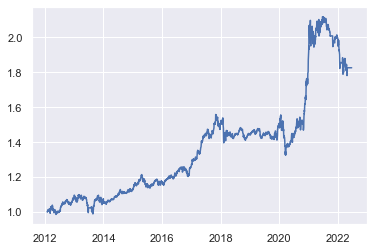

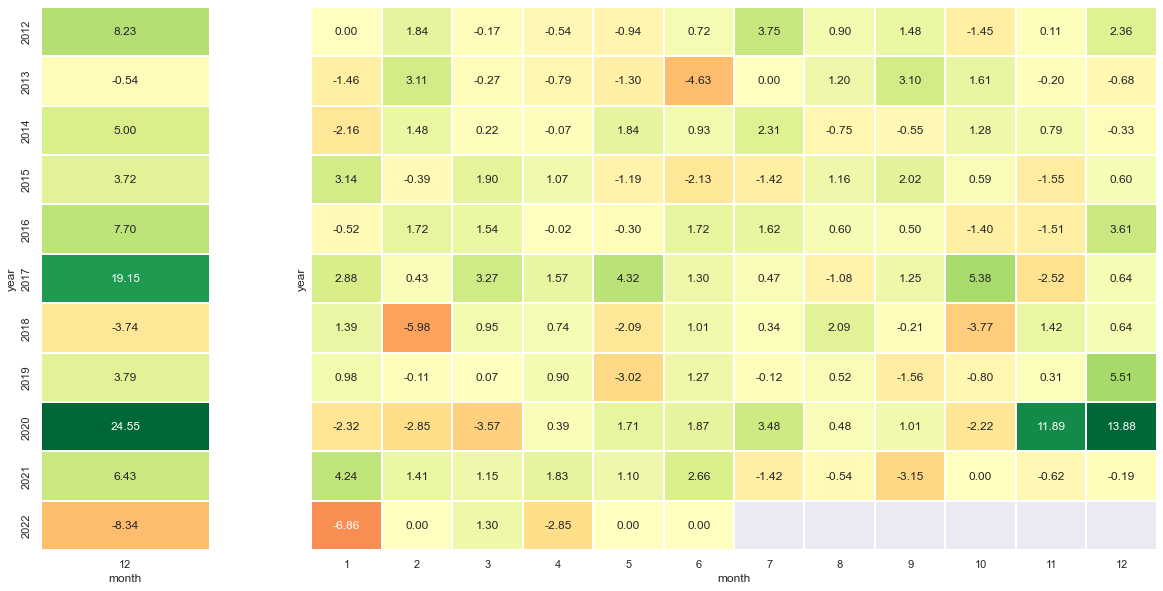

In [10]:
sns.set_theme()
monthPivot = monthData.pivot('year', 'month', 'monthReturn') # 월간수익률 피봇테이블
yearPivot = yearData.pivot('year', 'month', 'yearReturn') # 연간수익률 피봇테이블
plt.plot(momentumPortfolioCumReturn['cumReturn'])

f,(ax1,ax2) = plt.subplots(1,2, sharey=True, gridspec_kw={'width_ratios': [1, 5]}, figsize=(20, 10)) # 두 그래프 비율 1:5 설정
g1 = sns.heatmap(yearPivot, ax=ax1,annot=True, fmt='.2f',linewidths=.3, cmap="RdYlGn", center=0, cbar=False)
g2 = sns.heatmap(monthPivot,ax=ax2, annot=True, fmt='.2f',linewidths=.1, cmap="RdYlGn", center=0, cbar=False)



# 월간, 연간 수익률 시각화 함수

In [11]:
def getEvaluation(cumReturn):
    """
    cagr, dd, mdd
    투자 성과 지표 + 시각화
    """
    # cagr
    cagr = cumReturn.iloc[-1] ** (252/len(cumReturn))
    # mdd
    dd = (cumReturn.cummax() - cumReturn) / cumReturn.cummax() * 100
    mdd= dd.max()
    
    print(f"cagr: {cagr}\nmdd: {mdd}")
    
    cumReturn = pd.DataFrame(cumReturn)
    cumReturn.columns = ['cumReturn']
    cumReturn['year'] = cumReturn.index.year
    cumReturn['month'] = cumReturn.index.month

    # 월별 데이터, 연별 데이터
    monthData = cumReturn.drop_duplicates(['year', 'month'], keep="last")
    yearData = cumReturn.drop_duplicates('year', keep="last")

    # 월간수익률
    monthData['monthReturn'] = ((monthData['cumReturn'] / monthData['cumReturn'].shift(1).fillna(1))-1)*100
    
    # 연간수익률
    yearData['yearReturn'] = (yearData['cumReturn'] / yearData['cumReturn'].shift(1) -1)*100
    yearData.iloc[0, -1] = (yearData.iloc[0, 0] - 1) * 100 # 첫해 연말 수익률
    yearData.iloc[-1, -2] = 12 # 이번달 월을 강제로 12로 설정.. 보기 편하도록
    
    # 수익곡선, 낙폭 시각화
    f,(ax1,ax2) = plt.subplots(2,1, sharex=True, figsize=(20, 10))
    cumReturn['cumReturn'].plot(ax=ax1)
    (-1*dd).plot(ax=ax2)
    ax1.set_title("Cumulative Return & Draw Down")

    # 연간, 월간 수익률 시각화
    sns.set_theme()
    monthPivot = monthData.pivot('year', 'month', 'monthReturn') # 월간수익률 피봇테이블
    yearPivot = yearData.pivot('year', 'month', 'yearReturn') # 연간수익률 피봇테이블

    f,(ax1,ax2) = plt.subplots(1,2, sharey=True, gridspec_kw={'width_ratios': [1, 5]}, figsize=(20, 10)) # 두 그래프 비율 1:5 설정
    g1 = sns.heatmap(yearPivot, ax=ax1,annot=True, fmt='.2f',linewidths=.3, cmap="RdYlGn", center=0, cbar=False) # 연간수익률 히트맵
    g2 = sns.heatmap(monthPivot,ax=ax2, annot=True, fmt='.2f',linewidths=.1, cmap="RdYlGn", center=0, cbar=False) # 월간수익률 히트맵
    ax1.set_title("Annual Return")
    ax2.set_title("Monthly Return")

    return cagr, dd, mdd

cagr: 1.0218555694414413
mdd: 14.228099667139189


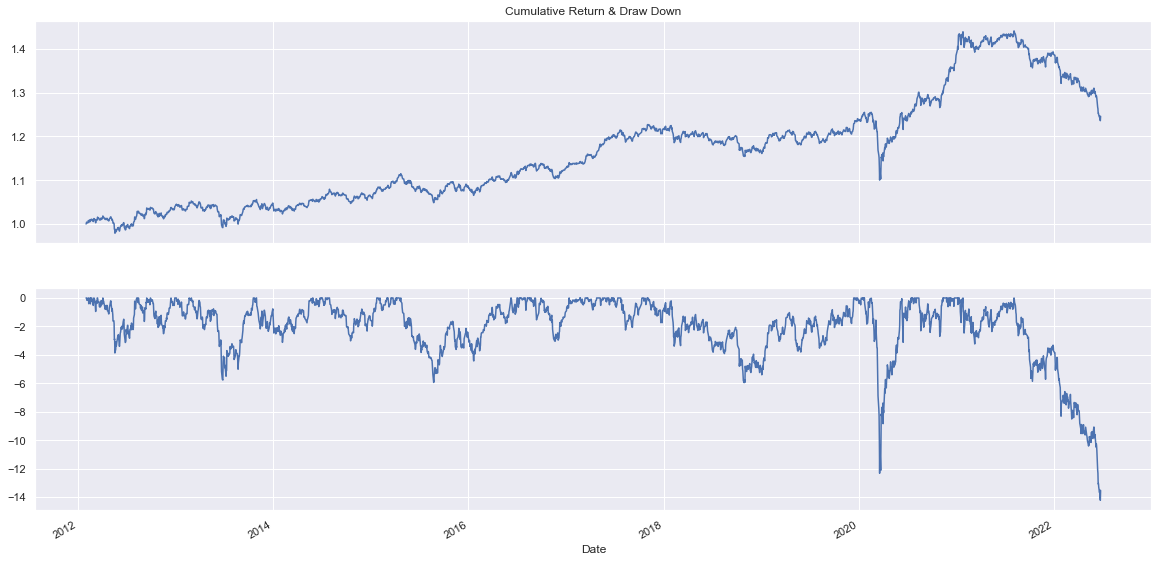

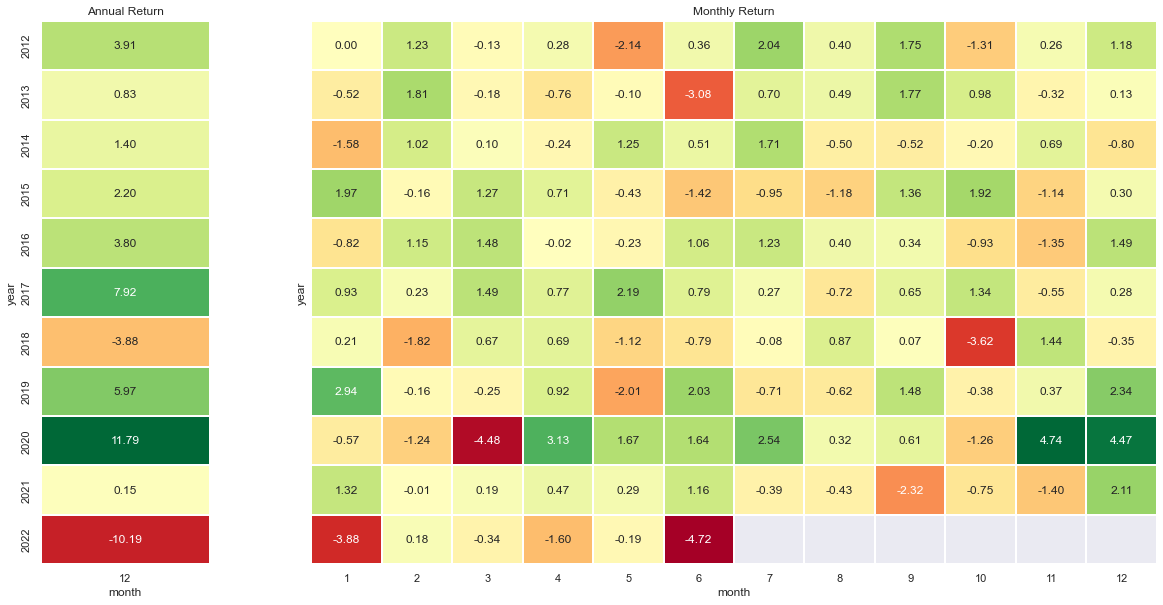

In [12]:
_, cumReturn = getRebalancingPortfolioResult(closeDataSet)
cagr, dd, mdd = getEvaluation(cumReturn)

# 자산배분 알림 시스템

1. 사용자가 원하는 전략을 선택한다. (평모스,VDD, FAA, GTAA 등..)
3. 사고 팔아야하는 자산의 종류와 비율을 반환한다.

* 평균모멘텀스코어 비중
* GTAA
* FAA
* VAA
* DAA

In [40]:
def getAvgMomentumScoreWeight(closeDataSet, n = 6):
    """
    평균 모멘텀 스코어 전략 자산배분 비중
    closeDataSet: 종가 데이터
    n: 모멘텀 기간 1~n
    return: 투자비중 weight df, 평균모멘텀 스코어 df
    """
    avgMomentumScore = 0 # 초기값
    dataSetOnRebalancingDate = closeDataSet.loc[getRebalancingDate(closeDataSet)] 
    
    # 1 ~ n개월 모멘텀 스코어 합
    for i in range(1, n+1):
        avgMomentumScore = np.where(dataSetOnRebalancingDate / dataSetOnRebalancingDate.shift(i) > 1, 1, 0) + avgMomentumScore
        
    avgMomentumScore = pd.DataFrame(avgMomentumScore, index=dataSetOnRebalancingDate.index, columns=dataSetOnRebalancingDate.columns) # dataframe 형변환
    avgMomentumScore = avgMomentumScore / 12 # 평균화
    weight = avgMomentumScore.divide(avgMomentumScore.sum(axis=1), axis=0).fillna(0) # 모멘텀 스코어에 따른 weight 계산
    return weight


def getGTAAWeight(closeDataSet, gtaaCol):
    """
    GTAA 전략 자산배분 비중
    """
    # gtaa 전략 종목 유니버스
    
    
    gtaaData = closeDataSet[gtaaCol]
    
    # 모멘텀 스코어 계산
    # 5개 자산에 각 20% 비중으로 투자하되, 모멘텀 스코어 0 미만인 자산의 비중만큼은 현금 보유
    # 모멘텀 스코어 = (가격 / 10개월 이동평균) - 1
    ma200 = gtaaData.rolling(window=200).mean() # 10개월 이동평균, 200일선
    momentumScore = (gtaaData / ma200) -1 # 모멘텀 스코어 계산
    momentumScore.dropna(inplace=True) # 결측치 버리기
    
    # 리밸런싱 일자
    gtaaRebalDate = getRebalancingDate(momentumScore) 
    
    # weightDf 계산하기
    # 5개 자산에 각 20% 비중으로 투자하되, 모멘텀 스코어 0 미만인 자산의 비중만큼은 현금 보유
    weightDf = pd.DataFrame(np.where(momentumScore > 0, 0.2, 0), index=momentumScore.index, columns=gtaaCol) 
    weightDf.index = pd.to_datetime(weightDf.index)
    weightDf = weightDf.loc[gtaaRebalDate]
    weightDf['Cash'] = 1 - weightDf.sum(axis=1)
    return weightDf


def getFAAWeight(closeDataSet, faaCol):
    """
    FAA 전략 자산배분 비중
    """
    faaData = closeDataSet[faaCol]
    
    # 리밸런싱 날짜
    faaRebalDate = getRebalancingDate(faaData)

    # 모멘텀 : 4개월 수익률
    faaRebalData = faaData.loc[faaRebalDate] # 리밸런싱 일자의 가격 데이터
    momentum4 = faaRebalData / faaRebalData.shift(4)
    momentum4Score = momentum4.rank(method="max", axis=1, ascending=False)
    
    # 변동성 : 4개월 일일수익률의 표준편차(standard deviation) 순위 (낮을수록 좋음)
    std4 = pd.DataFrame()
    # 상관성 : 4개월 하나의 자산과 다른 6개 자산간의 일일수익률의 상관성(correlation)의 합 순위 (낮을수록 좋음)
    corr4 = pd.DataFrame()
    reverseFaaRebalDate = faaRebalDate[::-1]

    for index, date in enumerate(reverseFaaRebalDate) :
        if index >= len(reverseFaaRebalDate) - 4:
            break
            
        # 4개월 전 시점
        before4month = reverseFaaRebalDate[index+4]
        
        # 일일 수익률
        dayReturn = getDayReturn(closeDataSet=faaData)

        # 4개월 일일수익률 표준편차
        std = dayReturn.loc[date:before4month:-1].std()
        std.name = date
        std4 = std4.append(std)
        
        # 4개월 일일수익률 상관성
        corr = (dayReturn.loc[date:before4month:-1].corr(method="pearson")).sum(axis=1)-1
        corr.name = date
        corr4 = corr4.append(corr)
    
    # 변동성 순위 정하고, 인덱스 오름차순으로 정렬
    std4Score = std4.rank(method="first", axis=1, ascending=True)
    std4Score = std4Score.sort_index(ascending=True)
    
    # 상관성 순위 정하고, 인덱스 오름차순으로 정렬
    corr4Score = corr4.rank(method="first", axis=1, ascending=True)
    corr4Score= corr4Score.sort_index(ascending=True)
    
    # 모멘텀, 표준편차, 상관성 데이터 시점 맞추기
    # 2010 ~
    momentum4 = momentum4.loc['2010':]
    momentum4Score = momentum4Score.loc['2010':]
    std4Score = std4Score.loc['2010':]
    corr4Score = corr4Score.loc['2010':]
    
    # 가중평균
    totalScore = (momentum4Score + 0.5 * (std4Score + corr4Score)).rank(method="first", axis=1, ascending=True)

    # 모멘텀 1 미만에 대해서는 현금투자,
    # 랭킹에서 상위 3가지 뽑아 내는 방법
    weight = (totalScore <= 3) & (momentum4 >= 1)
    faaWeight = weight.replace(True, 1/3).replace(False, 0)
    faaWeight['Cash'] = 1 - faaWeight.sum(axis=1)
    return faaWeight


def getVAAWeight(closeDataSet, vaaCol, vaaAttack, vaaDefense):
    """
    VAA 전략 자산배분 비중
    """
    vaaData = closeDataSet[vaaCol]
    
    # 모멘텀 스코어를 구하기
    # (최근 1개월 수익률x12) + (최근 3개월 수익률x4) + (최근 6개월 수익률x2) + (최근 12개월 수익률x1)
    rebalDate = getRebalancingDate(vaaData)
    vaaDataOnRebalDate = vaaData.loc[rebalDate]

    momentum1 = vaaDataOnRebalDate / vaaDataOnRebalDate.shift(1) -1
    momentum3 = vaaDataOnRebalDate / vaaDataOnRebalDate.shift(3) - 1
    momentum6 = vaaDataOnRebalDate / vaaDataOnRebalDate.shift(6) -1
    momentum12 = vaaDataOnRebalDate / vaaDataOnRebalDate.shift(12) -1

    momentumScore = 12*momentum1 + 4*momentum3 + 2*momentum6 + momentum12
    momentumScore.dropna(inplace=True)
    
    # 공격자산 4개 모멘텀 스코어가 전부 0 초과일 경우 가장 모멘텀스코어가 높은 공격자산에 몰빵
    # 공격자산 중 하나라도 모멘텀스코어가 0 이하일 경우 가장 모멘텀스코어가 높은 수비자산에 몰빵
    isAttack = (momentumScore[vaaAttack] > 0).all(axis=1)
    momentumScore['isAttack'] = isAttack
    vaaWeight = momentumScore.apply(applyGetVAAWegiht, axis=1)
    return vaaWeight
    
def applyGetVAAWegiht(row):
    isAttack = row["isAttack"]
    row = row.drop(labels=['isAttack'])
    row = pd.to_numeric(row)
    
    if isAttack:
        # 공격자산 중 가장 모멘텀 스코어가 높은 종목에 몰빵
        return pd.Series(row.index == row[vaaAttack].idxmax(), index=row.index, name=row.name).astype(int)

    # 수바자산 중 가장 모멘텀스코어가 높은 종목에 몰빵
    return pd.Series(row.index == row[vaaDefense].idxmax(), index=row.index, name=row.name).astype(int)


def getDAAWeight(closeDataSet, daaCol, daaAttack, daaDefense, daaCanary):
    """
    DAA 전략 자산배분 비중
    """
    daaData = closeDataSet[daaCol]
    daaData.dropna(inplace=True)
    
    # 모멘텀 스코어 계산
    rebalDate = getRebalancingDate(daaData)
    daaDataOnRebalDate = daaData.loc[rebalDate]

    momentum1 = daaDataOnRebalDate / daaDataOnRebalDate.shift(1) -1
    momentum3 = daaDataOnRebalDate / daaDataOnRebalDate.shift(3) - 1
    momentum6 = daaDataOnRebalDate / daaDataOnRebalDate.shift(6) -1
    momentum12 = daaDataOnRebalDate / daaDataOnRebalDate.shift(12) -1

    momentumScore = 12*momentum1 + 4*momentum3 + 2*momentum6 + momentum12
    momentumScore.dropna(inplace=True)
    
    # 카나리아 자산 모멘텀 스코어가 모두 0 이상일 때 공격 자산 중 모멘텀 스코어가 가장 큰 2개 자산을 보유
    # 카나리아 자산 중 하나의 자산만 모멘텀 스코어0 이상일 때 공격 자산 중 모멘텀 스코어가 가장 큰 2개 자산과 방어자산 1개
    # 카나리아 자산 중 하나라도 모멘텀스코어가 0 이하라면 수비 자산 중 모멘텀 스코어가 가장 큰 자산에 몰빵
    isAttack = (momentumScore[daaCanary] > 0).sum(axis=1)
    momentumScore['isAttack'] = isAttack
    daaWeight = momentumScore.apply(applyGetDAAWeight, axis=1)
    return daaWeight
    
def applyGetDAAWeight(row):
    isAttack = row["isAttack"]
    row = row.drop(labels=['isAttack'])
    row = pd.to_numeric(row)
    
    if isAttack == 2:
        # 카나리아 자산 모멘텀 스코어가 모두 0 초과일 때 공격 자산 중 모멘텀 스코어가 가장 큰 2개 자산을 보유
        top2 = row[daaAttack].nlargest(n=2).index
        result = pd.Series(row.index.isin(top2), index=row.index, name=row.name).astype(int).replace(1, 0.5)
        return result
    
    if isAttack == 1:
        # 카나리아 자산 중 하나의 자산만 모멘텀 스코어0 이상일 때 공격 자산 중 모멘텀 스코어가 가장 큰 자산과 방어자산
        topAttack = row[daaAttack].idxmax()
        topDefense = row[daaDefense].idxmax()
        result = pd.Series(row.index.isin([topAttack, topDefense]), index=row.index, name=row.name).astype(int).replace(1, 0.5)
        return result 
        
    # 카나리아 자산 중 하나라도 모멘텀스코어가 0 이하라면 수비 자산 중 모멘텀 스코어가 가장 큰 자산에 몰빵
    return pd.Series(row.index == row[daaDefense].idxmax(), index=row.index, name=row.name).astype(int)

In [13]:
dynamicData = pd.read_csv("동적자산배분데이터.csv", index_col=0, parse_dates=True)
dynamicData

,SHY,GSG,TLT,SPY,VTI,BND,VNQ,VWO,VEA,EWJ,...,HYG,VGK,SHV,UST,IWM,EEM,LQD,IEF,AGG,DBC
2009-01-02,74.71815,29.61,82.52249,72.54897,36.17632,54.50851,21.13848,18.37935,19.22968,31.71652,...,34.46859,25.02595,103.7816,NaN,42.24755,20.46180,63.88389,75.41508,74.28091,21.93
2009-01-05,74.86900,30.63,80.39471,72.46313,36.16846,54.27989,20.74913,18.67543,18.94444,30.92608,...,36.13357,24.76346,103.8569,NaN,42.39898,20.72774,64.32201,75.28307,75.46452,22.16
2009-01-06,74.90449,31.20,79.58615,72.94700,36.46711,53.93349,21.78539,19.00852,19.11141,30.62966,...,36.43835,25.21161,103.9040,NaN,43.11404,21.19705,64.42996,75.23648,75.04128,22.74
2009-01-07,74.85125,29.02,79.89822,70.76178,35.44540,54.09976,21.05462,18.00184,18.88182,30.33324,...,35.77874,24.75066,103.9229,NaN,41.84376,19.97685,63.89024,75.25201,74.35264,21.58
2009-01-08,74.86900,28.62,79.83439,71.05054,35.60259,54.00970,20.89888,17.89081,19.10445,30.76140,...,35.26014,25.02595,103.8099,NaN,42.04565,19.89081,64.34741,75.45390,73.78593,21.66
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-16,82.40000,25.41,111.72000,366.65000,183.02000,74.30000,87.04000,41.27000,40.96000,52.64000,...,73.82000,53.21000,110.0100,51.61,163.90000,39.52000,109.21000,100.17000,100.35000,29.71
2022-06-17,82.38000,24.50,112.08000,365.86000,183.71000,74.34000,87.70000,41.45000,40.82000,52.06000,...,74.05000,53.22000,110.0100,51.74,165.18000,39.67000,109.43000,100.20000,100.34000,28.65
2022-06-21,82.35000,24.48,110.18000,375.07000,188.16000,74.00000,88.92000,41.80000,40.91000,52.60000,...,74.00000,53.03000,110.0200,51.15,168.14000,40.31000,108.33000,99.68000,99.94000,28.58
2022-06-22,82.59000,24.01,113.21000,374.39000,188.13000,74.61000,90.05000,41.11000,40.53000,52.34000,...,73.98000,52.68000,110.0600,52.47,167.82000,39.59000,109.12000,100.94000,100.79000,28.07


In [41]:
gtaaCol = ['SPY', 'EFA', "IEF", "DBC", "VNQ"]

faaCol = ['VTI', 'VEA', 'VWO', 'SHY', 'BND', 'DBC', 'VNQ']

vaaCol = ['SPY', "VEA", "EEM", "AGG", "LQD", "SHY", "IEF"]
vaaAttack = ['SPY', "VEA", "EEM", "AGG"]
vaaDefense = ["LQD", "SHY", "IEF"]

daaCol = ['SPY', "IWM", "QQQ", "VGK", "EWJ", "VWO", "VNQ", "GSG", "GLD", "TLT", "HYG", "LQD", "SHY", "IEF","BND"]
daaAttack = ['SPY', "IWM", "QQQ", "VGK", "EWJ", "VWO", "VNQ", "GSG", "GLD", "HYG", "LQD"]
daaDefense = [ "SHY", "IEF", "TLT"] # UST 데이터 시점 문제로 TLT로 대체
daaCanary = ["VWO", "BND"]

# avgMomentumScoreWeight = getAvgMomentumScoreWeight # 자산 유니버스는 입맛대로 해서 테스트 해보기
gtaaWeight = getGTAAWeight(dynamicData, gtaaCol)
faaWeight = getFAAWeight(dynamicData, faaCol)
vaaWeight = getVAAWeight(dynamicData, vaaCol, vaaAttack, vaaDefense)
daaWeight = getDAAWeight(dynamicData, daaCol, daaAttack, daaDefense, daaCanary)